In [ ]:
import shutil
shutil.rmtree('/content/train/')
shutil.rmtree('/content/test/')

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip -qq "/content/drive/MyDrive/pokemon/train.zip" -d "/content/train"
!unzip -qq "/content/drive/MyDrive/pokemon/test.zip" -d "/content/test"

## Loading and preprocessing dataset

In [ ]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models,layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, Flatten, MaxPool2D, Dense, ReLU, BatchNormalization, Add, Dropout, GlobalAveragePooling2D, DepthwiseConv2D
from tensorflow.keras.applications.mobilenet import MobileNet
from PIL import Image
import random

# 포켓몬 이미지가 저장된 기본 디렉토리
base_dir = '/content'

# Image data generator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # 80% train, 20% validation
)

# RGBA 형식으로 변경
def load_and_convert_image(img_path):
    img = Image.open(img_path)
    img = img.convert("RGBA")
    return img

train_datagen.load_and_convert_image = load_and_convert_image

test_datagen = ImageDataGenerator(rescale=1./255, rotation_range=40, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')

# Train 데이터셋 생성
train_generator = train_datagen.flow_from_directory(
    base_dir + "/train",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

# Validation 데이터셋 생성
validation_generator = train_datagen.flow_from_directory(
    base_dir + "/train",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# Test 데이터셋 생성
test_generator = test_datagen.flow_from_directory(base_dir + "/test", target_size=(224, 224), batch_size=32, class_mode='categorical')

Found 1244 images belonging to 20 classes.
Found 302 images belonging to 20 classes.
Found 220 images belonging to 20 classes.


In [ ]:
# 클래스별 이미지 수 출력
class_counts = train_generator.classes
unique_classes = list(set(class_counts))

for class_id in unique_classes:
    class_name = list(train_generator.class_indices.keys())[class_id]
    count = sum(class_counts == class_id)
    print(f"Class '{class_name}': {count} images")

Class '1': 135 images
Class '10': 37 images
Class '16': 40 images
Class '19': 40 images
Class '21': 58 images
Class '23': 39 images
Class '25': 112 images
Class '27': 36 images
Class '35': 40 images
Class '37': 40 images
Class '39': 41 images
Class '4': 98 images
Class '41': 43 images
Class '43': 41 images
Class '50': 72 images
Class '52': 64 images
Class '54': 50 images
Class '58': 78 images
Class '66': 52 images
Class '7': 128 images


## Model instantiation and training

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# 모델 생성
base_model = MobileNet(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

model = tf.keras.models.Sequential([
    base_model,
    Flatten(),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dense(train_generator.num_classes, activation='softmax')
])

# 모델 컴파일
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# 훈련
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

Epoch 1/10
 9/39 [=====>........................] - ETA: 15s - loss: 35.0661 - accuracy: 0.1127

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


39/39 [==============================] - 65s 1s/step - loss: 11.8104 - accuracy: 0.3087 - val_loss: 5.2743 - val_accuracy: 0.2483
Epoch 2/10
39/39 [==============================] - 51s 1s/step - loss: 1.1112 - accuracy: 0.6760 - val_loss: 3.0636 - val_accuracy: 0.4238
Epoch 3/10
39/39 [==============================] - 42s 1s/step - loss: 0.5550 - accuracy: 0.8392 - val_loss: 2.0830 - val_accuracy: 0.6722
Epoch 4/10
39/39 [==============================] - 37s 943ms/step - loss: 0.4278 - accuracy: 0.8794 - val_loss: 1.1093 - val_accuracy: 0.7781
Epoch 5/10
39/39 [==============================] - 36s 932ms/step - loss: 0.3747 - accuracy: 0.8947 - val_loss: 0.7265 - val_accuracy: 0.8477
Epoch 6/10
39/39 [==============================] - 36s 917ms/step - loss: 0.2375 - accuracy: 0.9244 - val_loss: 0.4344 - val_accuracy: 0.9139
Epoch 7/10
39/39 [==============================] - 39s 998ms/step - loss: 0.2335 - accuracy: 0.9268 - val_loss: 0.8718 - val_accuracy: 0.8742
Epoch 8/10
39/39 [

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functi  (None, 7, 7, 1024)        3228864   
 onal)                                                           
                                                                 
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 dropout (Dropout)           (None, 50176)             0         
                                                                 
 dense (Dense)               (None, 512)               25690624  
                                                                 
 dense_1 (Dense)             (None, 20)                10260     
                                                                 
Total params: 28929748 (110.36 MB)
Trainable params: 28907860 (110.27 MB)
Non-trainable params: 21888 (85.50 KB)
_________

In [ ]:
# '원래 인덱스' : ImageGenerator 자동 생성 인덱스
print(train_generator.class_indices)

{'1': 0, '10': 1, '16': 2, '19': 3, '21': 4, '23': 5, '25': 6, '27': 7, '35': 8, '37': 9, '39': 10, '4': 11, '41': 12, '43': 13, '50': 14, '52': 15, '54': 16, '58': 17, '66': 18, '7': 19}


7/7 [==============================] - 3s 443ms/step - loss: 0.9756 - accuracy: 0.8455
Test Accuracy: 84.55%


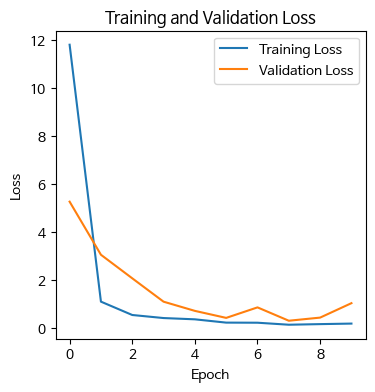

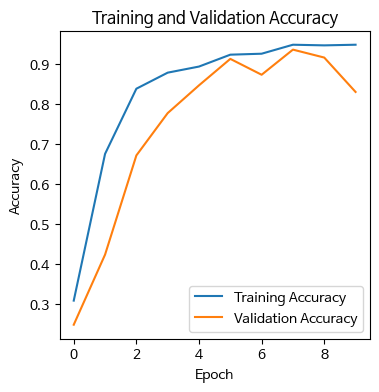

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 모델 테스트
test_loss, test_accuracy = model.evaluate(test_generator) # test_generator
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

plt.figure(figsize=(4, 4))

# Training and Validation loss 그래프
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(4, 4))

# Training and Validation accuracy 그래프
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
import pandas as pd
# 구글 드라이브 csv 파일 경로 파싱
url = "https://drive.google.com/file/d/1svkg2eLagjCPwfAGynKSZsaTrTiEFBSP/view?usp=sharing"
path = 'https://drive.google.com/uc?id='+url.split('/')[-2]

# 포켓몬 CSV 파일 읽고 정보 추출
pokemon_df = pd.read_csv(path, encoding='cp949')

1/1 [==============================] - 0s 20ms/step


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


1/1 [==============================] - 0s 20ms/step


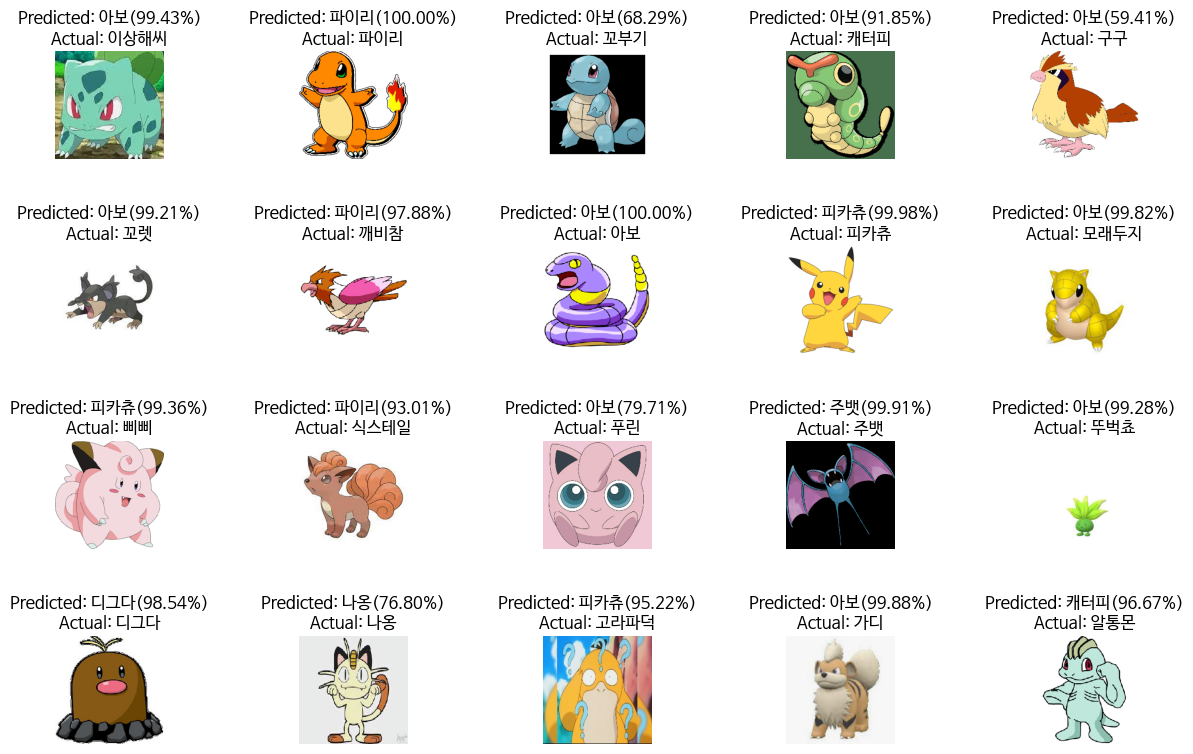

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# 이미지 로드 및 사이즈 조정
def preprocess_img(test_image_name):
  # 원본 이미지 로드
  test_image = load_img(test_image_name, target_size=(224, 224))
  # predict를 위해 이미지 가공
  preprocess_image = img_to_array(test_image)
  preprocess_image = np.expand_dims(preprocess_image, axis=0)
  return test_image, preprocess_image

# label 목록 저장 (오름차순 str)
directory = base_dir + "/test"
labels = [int(label) for label in os.listdir(directory)]
labels.sort()
labels = [str(label) for label in labels]

# 각 라벨당 test 이미지 한 장씩 저장
test_data = []
for label in labels:
  folder = os.path.join(directory,label)
  rnd_idx = str(np.random.randint(0, 11)) +'.jpg' # 가져올 이미지 번호 랜덤으로 지정
  img, p_img = preprocess_img(os.path.join(folder, rnd_idx))
  test_data.append((label, img, p_img)) # (도감 번호, 원본 이미지, 가공된 이미지)

label_map = test_generator.class_indices

# 저장한 이미지에 대해 predict
plt.figure(figsize = (15 , 9))
plt.rcParams['font.family'] = 'NanumBarunGothic'

for idx, data in enumerate(test_data):
  result = model.predict(data[2])
  predicted_class = np.argmax(result, axis=1)
  predicted_no = int(str([key for key, value in label_map.items() if value == predicted_class][0]))
  predicted_pokemon_info = pokemon_df[pokemon_df['No.'] == predicted_no].iloc[0]
  predicted_probability = np.max(result) * 100

  actual_no = int(data[0])
  actual_pokemon_info = pokemon_df[pokemon_df['No.'] == actual_no].iloc[0]

  plt.subplot(4, 5, idx+1)
  plt.subplots_adjust(hspace = 0.8 , wspace = 0.3)
  plt.axis('off')
  plt.imshow(data[1])
  plt.title(f"Predicted: {predicted_pokemon_info['kor_name']}({predicted_probability:.2f}%)\nActual: {actual_pokemon_info['kor_name']}")

Saving 00000001.png to 00000001.png
1/1 [==============================] - 0s 20ms/step
100.00% 확률로 25번 포켓몬 "피카츄"이고, Type1은 "전기"이고, Type2는 "None"입니다.


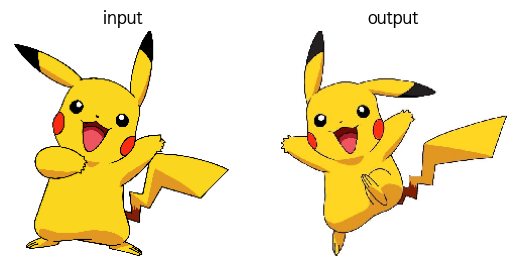

In [ ]:
from google.colab import files

# 입력 이미지 업로드
uploaded_test_images = files.upload()

# 업로드한 이미지 파일명 가져오기
test_image_name = list(uploaded_test_images.keys())[0]  # 첫 번째 업로드한 이미지 이름

# 이미지 로드 및 사이즈 조정
test_image = load_img(test_image_name, target_size=(224, 224))
preprocess_image = img_to_array(test_image)
preprocess_image = np.expand_dims(preprocess_image, axis=0)

# 클래스 예측
result = model.predict(preprocess_image)
#print(result)
predicted_class = np.argmax(result, axis=1)
#print(predicted_class)

# 예측한 클래스에 해당하는 포켓몬 정보 찾기
predicted_class = np.argmax(result, axis=1)
predicted_no = int(str([key for key, value in label_map.items() if value == predicted_class][0]))
predicted_pokemon_info = pokemon_df[pokemon_df['No.'] == predicted_no].iloc[0]
predicted_image = load_img(base_dir + "/test/" + str(predicted_no) + "/0.jpg", target_size=(224, 224))

# 예측 확률 계산
predicted_probability = np.max(result) * 100

# Type1 및 Type2 정보 가져오기 (없는 경우 'None'으로 처리)
type1 = predicted_pokemon_info['kor_type_1'] if not pd.isna(predicted_pokemon_info['kor_type_1']) else 'None'
type2 = predicted_pokemon_info['kor_type_2'] if not pd.isna(predicted_pokemon_info['kor_type_2']) else 'None'

# 결과 출력
plt.subplot(1, 2, 1)
plt.imshow(test_image)
plt.title("input")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(predicted_image)
plt.title("output")
plt.axis('off')

print(f"{predicted_probability:.2f}% 확률로 {predicted_no}번 포켓몬 \"{predicted_pokemon_info['kor_name']}\"이고, Type1은 \"{type1}\"이고, Type2는 \"{type2}\"입니다.")